<a href="https://colab.research.google.com/github/salmenhsairi/EndOfStudiesProjectNotebooks/blob/main/GPT3ConsistencyTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q openai
! pip install datasets

In [ ]:
import re
import random
import os
import json
import openai
import time
import itertools
import signal

from datasets import load_dataset
from random import sample

random.seed(42)

In [ ]:
import signal
def signal_handler(signum, frame):
    raise Exception("Timed out!")
signal.signal(signal.SIGALRM, signal_handler)  

<Handlers.SIG_DFL: 0>

## GPT3 60 Document Completion

In [ ]:
# Setting openai API key
os.environ['OPENAI_API_KEY'] = 'Put your openai API key here'
openai.api_key = os.getenv("OPENAI_API_KEY")

### GPT3 Input construction


In [ ]:
entities_to_extract_example = ["MEDICAL_CONDITION", "MEDICINE", "PATHOGEN"]
text_example = "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]"
prompt_example = """
"While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]"

Extract MEDICAL_CONDITION, MEDICINE, PATHOGEN from the text from the text in in format :
{ 
"MEDICAL_CONDITION": Array<String>, 
"MEDICINE": Array<String> , 
"PATHOGEN" : Array<String>, 
}

{
"""

In [ ]:
# a simple function that aims to prepare the prompt for the model 
# based on the document and the entities to extract from the doc
def generate_prompt(text,entities_to_extract):
  if not isinstance(text,str) or not isinstance(entities_to_extract,list):
    raise (ValueError('check input format'))
  entities_text = ", ".join(entities_to_extract)
  output_format = "\n".join([f'"{entity}"'+": Array<String>," for entity in entities_to_extract])
  prompt = f'''"{text}"

Extract {entities_text} from the text in a JSON object in format:
{{
{output_format[:-1]}
}}

{{'''
  return prompt

In [ ]:
# function test
with open('prompt_output.txt','w') as pt:
  prompt = generate_prompt(text_example,entities_to_extract_example)
  pt.write(prompt)

### Dealing with Data sources

In [ ]:
# https://huggingface.co/datasets/conll2003
conll_datasets = load_dataset('conll2003')
# https://huggingface.co/datasets/ncbi_disease
ncbi_disease_dataset = load_dataset('ncbi_disease')

In [ ]:
colnn_ents = conll_datasets["train"].features['ner_tags'].feature.names
ncbi_disease_ents = ncbi_disease_dataset['train'].features['ner_tags'].feature.names

In [ ]:
colnn_unique_ents = set([ent[2:] for ent in colnn_ents if ent != 'O'])
ncbi_disease_unique_ents = set([ent[2:] for ent in ncbi_disease_ents if ent != 'O'])

In [ ]:
colnn_dict = conll_datasets["train"].to_dict()
ncbi_disease_dict = ncbi_disease_dataset['train'].to_dict()

In [ ]:
# a function to keep only tokens and NER tags within documents
def clean_dict(dataset_dict):
  keys_origin = list(dataset_dict.keys())
  for key in keys_origin:
    if key not in ['tokens','ner_tags']:
      dataset_dict.pop(key)
      print()

In [ ]:
clean_dict(colnn_dict)
clean_dict(ncbi_disease_dict)
assert list(colnn_dict.keys()) == list(ncbi_disease_dict.keys()) == ['tokens','ner_tags']

In [ ]:
def get_dataset_texts(examples_dict):
  texts = list()
  for example in examples_dict['tokens']:
      text = ' '.join([token for token in example])
      texts.append(text)
  return texts

In [ ]:
# colnn_texts = get_dataset_texts(colnn_dict)
# ncbi_disease_texts = get_dataset_texts(ncbi_disease_dict)

In [ ]:
def has_entities(dataset_dict,dataset_ents,text_index):
    entities = dataset_dict['ner_tags'][text_index]
    if all(map(lambda x : x == dataset_ents.index("O"),entities)):
      return False
    return True

In [ ]:
def generate_text_sample(dataset_dict,dataset_ents,sample_size=25,text_length=30):
    texts = get_dataset_texts(dataset_dict)
    while True:
        sampled = sample(texts,sample_size)
        if all(map(lambda text : (len(text) >= text_length) and 
           (has_entities(dataset_dict,dataset_ents,texts.index(text))),sampled)):
          return sampled

In [ ]:
def get_text_sample(dataset_dict,dataset_ents,sample_size=25):
  try:
    signal.alarm(5)
    dataset_sample = generate_text_sample(dataset_dict,dataset_ents)
  except Exception as e:
    dataset_sample = []
    num_chunks = sample_size // 10
    rest = sample_size % 10
    for i in range(num_chunks):
      dataset_sub_sample = generate_text_sample(dataset_dict,dataset_ents,sample_size=10)
      dataset_sample.extend(dataset_sub_sample)
    dataset_sample.extend(generate_text_sample(dataset_dict,dataset_ents,sample_size=rest))
  return dataset_sample

In [ ]:
colnn_sample = get_text_sample(colnn_dict,colnn_ents)

In [ ]:
ncbi_disease_sample = get_text_sample(ncbi_disease_dict,ncbi_disease_ents)

### Loading Job Descriptions dataset

In [ ]:
with open('/content/128 document with entities only.json','r') as job_dataset:
  dataset = json.load(job_dataset,encoding='utf-8')
  job_description_sample = sample([example['document'] for example in dataset],25)
  job_description_unique_ents = set(['JOB_ROLE', 'PROFESSIONAL_SKILLS', 'YEARS_OF_EXPERIENCE', 'DIPLOMA', 'DIPLOMA_MAJOR'])

In [ ]:
# Check Data Samples

# colnn_sample
# ncbi_disease_sample
job_description_sample

### preparing input prompts for GPT model

In [ ]:
colnn_prompts = [generate_prompt(text,list(colnn_unique_ents)) for text in colnn_sample]
ncbi_disease_prompts = [generate_prompt(text,list(ncbi_disease_unique_ents)) for text in ncbi_disease_sample]
job_description_prompts = [generate_prompt(text,list(job_description_unique_ents)) for text in job_description_sample]

In [ ]:
# check a prompt example
with open('prompt_test.txt','w') as pt:
  prompt = ncbi_disease_prompts[19]
  pt.write(prompt)

In [ ]:
def read_openai_response(response):
  response_object_str = r"""{""" + r"""{0}""".format(response[:response.find('}')+1])
  if response_object_str.find(',\n}') != -1:
    response_object_str = response_object_str.replace(',\n}','\n}')
  response_object_dict = json.loads(response_object_str,encoding='utf-8')
  return response_object_dict

In [ ]:
def extract_prompt_entities(prompt):
  start = prompt.find('Extract') + len('Extract')
  end = prompt.find('from the text')
  entities = prompt[start:end].strip().split(',')
  return [entity.strip() for entity in entities]

In [ ]:
def verify_response_keys(prompt,response):
  actual_entities = extract_prompt_entities(prompt)
  extracted_entities = list(response.keys())
  return actual_entities == extracted_entities

In [ ]:
# API Docs https://beta.openai.com/docs/api-reference/completions/create

def call_openai_api(prompt,temperature=0.6,max_tokens=256):
  if not isinstance(prompt,list):
    prompt = [prompt]
  response = openai.Completion.create(
    model="text-davinci-002",
    prompt=prompt,
    temperature=temperature,
    max_tokens=max_tokens,
    logprobs = 1,
    # top_p=1, #generally recommended altering this or temperature but not both.
    logit_bias = {"50256": -100}, # prevent the <|endoftext|> token from being generated.
    frequency_penalty=0,
    presence_penalty=0
  )
  open_ai_response_object = response.to_dict_recursive()
  response_objects = []
  errors = []
  for i,prompt_item in enumerate(prompt):
    response_object_str = open_ai_response_object['choices'][i]['text']
    try:
      response_object_dict = read_openai_response(response_object_str)
      assert verify_response_keys(prompt_item,response_object_dict)
      response_objects.append(response_object_dict)
    except Exception as e:
      errors.append({"index":i,"response_str":response_object_str,"error_message":e})
  return response_objects,errors

In [ ]:
# response_test = call_openai_api(colnn_prompts[5])

In [ ]:
# prompts = {'colnn':colnn_prompts,'disease':ncbi_disease_prompts,'job':job_description_prompts}

In [ ]:
# we need to reduce the requested prompts to 20 as the maximum allowed
colnn_test,colnn_errors = call_openai_api(colnn_prompts[:20],max_tokens=256)
ncbi_disease_test,ncbi_disease_errors = call_openai_api(ncbi_disease_prompts[:20],max_tokens=256)
job_description_test,job_description_errors = call_openai_api(job_description_prompts[:20],max_tokens=512)

In [ ]:
# 20 docs response time range regarding max_length 15->12
assert len(ncbi_disease_test) == 20
assert len(colnn_test) == 20
assert len(job_description_test) == 20 # max length = 265 resulted in 2 errors

In [ ]:
def get_JSON_report(prompts,responses,name):
  report_objects = []
  for i in range(20):
    report_object = dict()
    report_object['prompt'] = prompts[:20][i]
    report_object['GPT_response_body'] = responses[i]
    report_objects.append(report_object)
  with open(f'report_{name}.json','w') as rep:
    json.dump(report_objects,rep,ensure_ascii=True)

In [ ]:
get_JSON_report(colnn_prompts,colnn_test,'colnn')
get_JSON_report(ncbi_disease_prompts,ncbi_disease_test,'ncbi_disease')
get_JSON_report(job_description_prompts,job_description_test,'job_description')

In [ ]:
# response_object_dict = json.loads(response_object_str,encoding='utf-8')

## Error analysis

Text(0.5, 1.0, 'Global Error Rate')

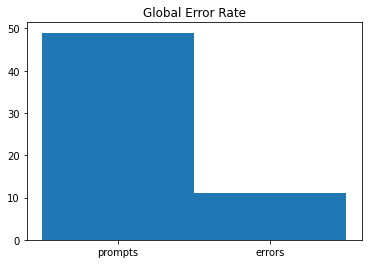

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
prompt_count = 60
error_count = sum([len(colnn_errors),len(ncbi_disease_errors),len(job_description_errors)])
correct_count = prompt_count - error_count
fig, ax  = plt.subplots()
ax.bar([1, 2], [correct_count,error_count], width=1,
       tick_label=['successes', 'errors'], align='center')
plt.title("Global Error Rate")

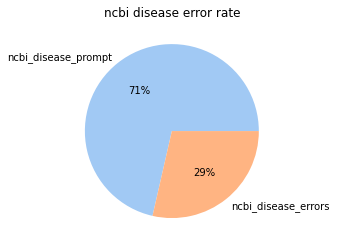

In [ ]:
data = [20,len(ncbi_disease_errors)]
labels = ['ncbi_disease_success', 'ncbi_disease_errors']
colors = sns.color_palette('pastel')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("ncbi disease error rate")
plt.show()

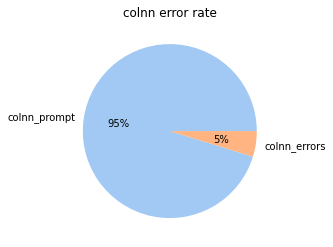

In [ ]:
data = [20,len(colnn_errors)]
labels = ['colnn_success', 'colnn_errors']
colors = sns.color_palette('pastel')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("colnn error rate")
plt.show()

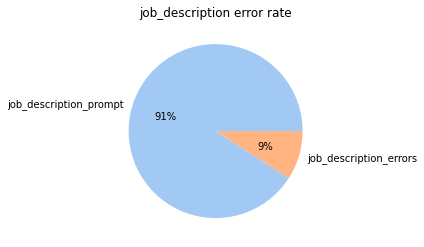

In [ ]:
data = [20,len(job_description_errors)]
labels = ['job_description_success', 'job_description_errors']
colors = sns.color_palette('pastel')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("job_description error rate")
plt.show()